In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random

Need to make the function `test_bootstrap_universal` work for weighted and directed graphs

In [3]:
"""homogenous weighted SBM code (from my project, is Bernoulli trials)"""
# Network generation --------------------------------------------------------
random.seed(10)

n = 300  # number of nodes
K = 2     # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []
B_list.append(np.array([[0.4, 0.2], [0.2, 0.7]]))


In [4]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [5]:
random.seed(10)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
"""Have modified this to be a draw for integers between 0 and 10 for no. connections"""
A_t = np.random.binomial(n=10, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

As = As.astype(int)
P = np.column_stack(P_list)

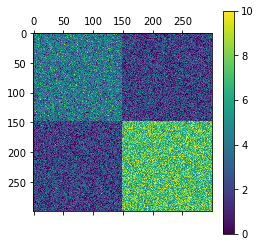

In [6]:
# Sample drawn using the above P in a Binom(10, P) - this is the Observed A matrix
cax = plt.matshow(As)
plt.colorbar(cax)
plt.show()

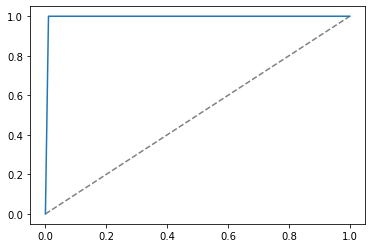

1.0

In [8]:
A_obs = As.astype(float)
p_vals, A_boots = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_boots[0]

plot_power(p_vals, plot=True)

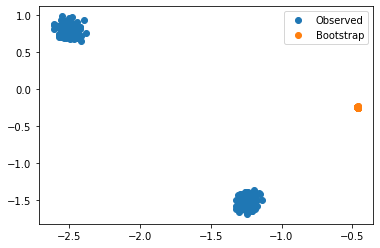

In [8]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

Now need to make this work, cos the test_bootstrap function doesn't do anything with weights

In [9]:
def multiply_with_weights(A, w1, w2):
    # Reshape w1 and w2 to have dimensions (n, 1)
    w1_reshaped = w1[:, np.newaxis]  # shape (n, 1)
    w2_reshaped = w2[np.newaxis, :]  # shape (1, n)
    
    # Perform element-wise multiplication
    M = w1_reshaped * w2_reshaped * A
    
    return M

In [10]:
A = A_obs
d=2
n_neighbors=5
B = 100

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the "weighted" P matrix (idk how you'd sample from this) -------------------------------
P_est = P_est_from_A_obs(n, A_obs, n_neighbors=n_neighbors, indices=indices)

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Adjusted P_est matrix ( not sure if this will be in [0,1]) -------------------------------
P_est_adj = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if (out_weights[i]*in_weights[j]) == 0:
            P_est_adj[i,j] = 0
        else:
            P_est_adj[i,j] = (1/(np.sqrt((out_weights[i]*in_weights[j])))) * P_est[i,j]

# Check matrix range
check_matrix_range(P_est_adj)

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_adj = make_inhomogeneous_rg(P_est_adj)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_adj)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

Matrix values are within the range [0, 1].


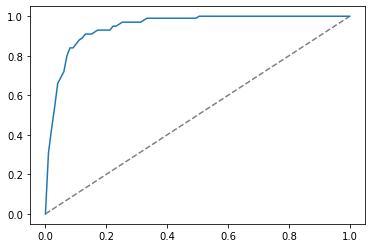

0.69

In [11]:
plot_power(p_vals, plot=True)

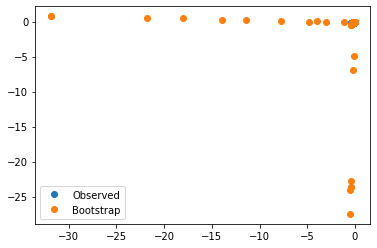

In [12]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

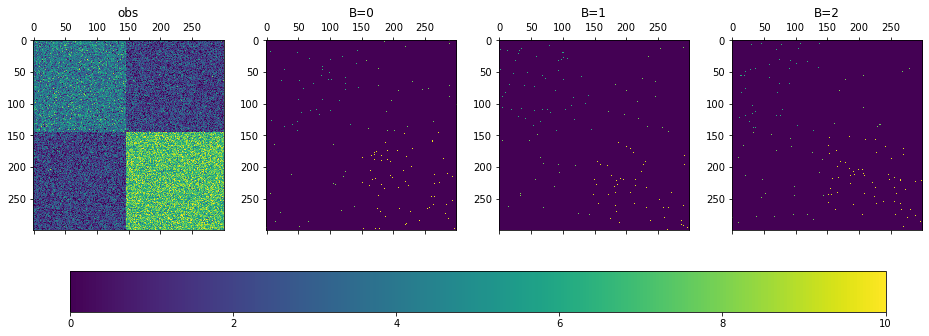

In [13]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

In [14]:
"""method 2"""
n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Binarise A using a threshold -------------------------------
quantile_75 = np.quantile(A, q=0.75)
quantile = np.quantile(A, q=0.8)
A_bin = np.where(A > quantile, 1, 0)

# Estimate the binarised P from the binarised A -------------------------------
P_est_bin = P_est_from_A_obs(n, A_bin, n_neighbors=n_neighbors, indices=indices)

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_bin = make_inhomogeneous_rg(P_est_bin)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_bin)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

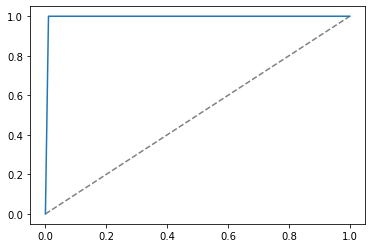

1.0

In [15]:
plot_power(p_vals, plot=True)

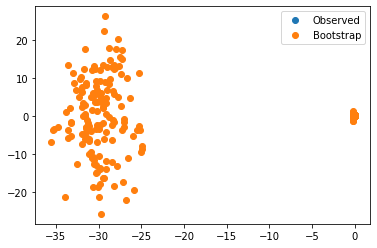

In [16]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

In [17]:
# append A_obs to the front of A_boots list
mats = [A_obs] + A_boots
len(mats)


101

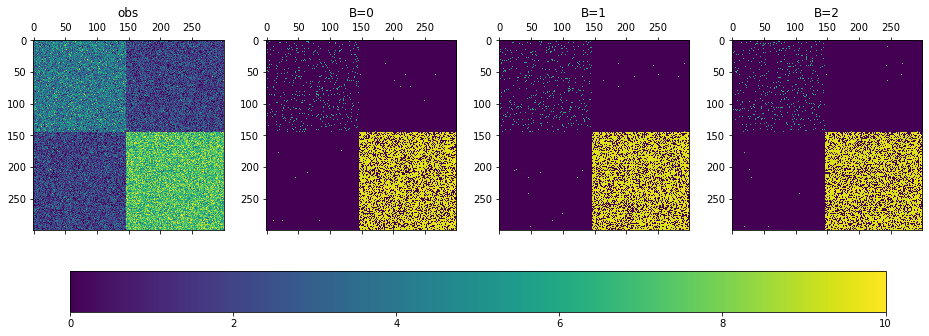

In [18]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

In [19]:
"""method 3"""
n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the binarised P from the binarised A -------------------------------
P_est = P_est_from_A_obs(n, A, n_neighbors=n_neighbors, indices=indices)
pmax = np.max(P_est)
P_est_adj = P_est/pmax

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_adj = make_inhomogeneous_rg(P_est_adj)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_adj)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

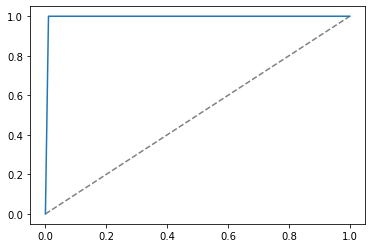

1.0

In [20]:
plot_power(p_vals, plot=True)

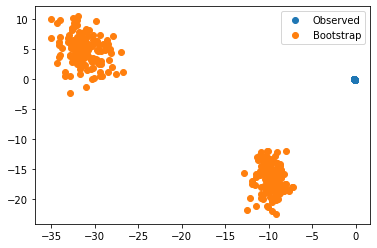

In [21]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

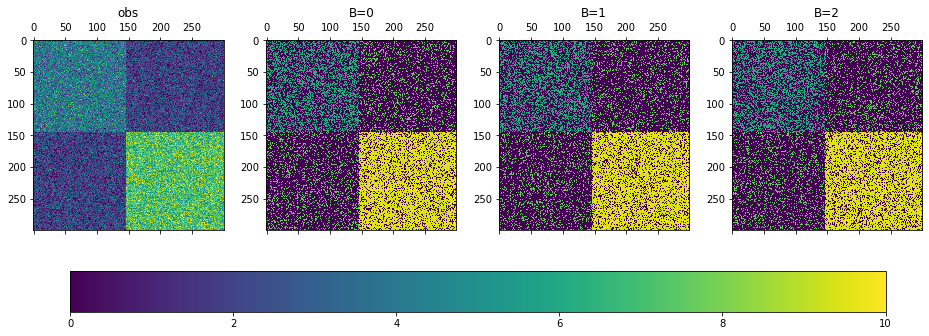

In [22]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

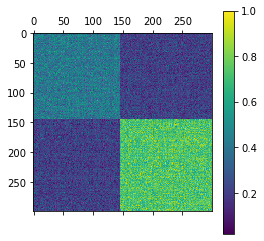

In [23]:
plt.matshow(P_est_adj)
plt.colorbar()

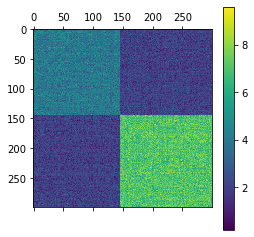

In [24]:
plt.matshow(P_est)
plt.colorbar()

In [25]:
pmax

9.600000000000001

In [26]:
"""method4"""
n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Binarise A using many different thresholds -------------------------------
P_q_list = []
quantiles = np.arange(0.05, 0.95, 0.18)
for q in quantiles:
    quantile = np.quantile(A, q=q)
    A_bin = np.where(A > quantile, 1, 0)
    P_est_bin = P_est_from_A_obs(n, A_bin, n_neighbors=n_neighbors, indices=indices)
    P_q_list.append(P_est_bin)

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_q_list = []
    for q in range(len(P_q_list)):
        A_est_bin = make_inhomogeneous_rg(P_q_list[q])
        A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_bin)[0]
        A_q_list.append(A_est)

    A_est_bin = np.sum(A_q_list, axis=0) / len(P_q_list)
    A_est = multiply_with_weights(np.sqrt(out_weights), np.sqrt(in_weights), A_est_bin)[0]

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)


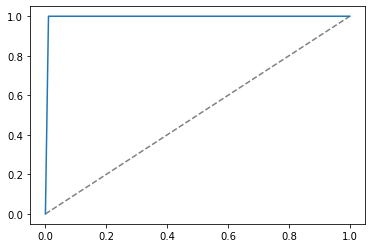

1.0

In [27]:
plot_power(p_vals, plot=True)

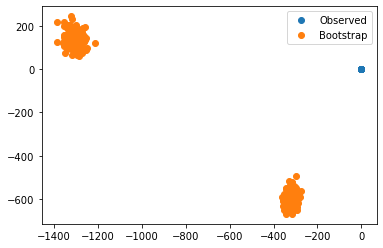

In [28]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)

plt.legend()

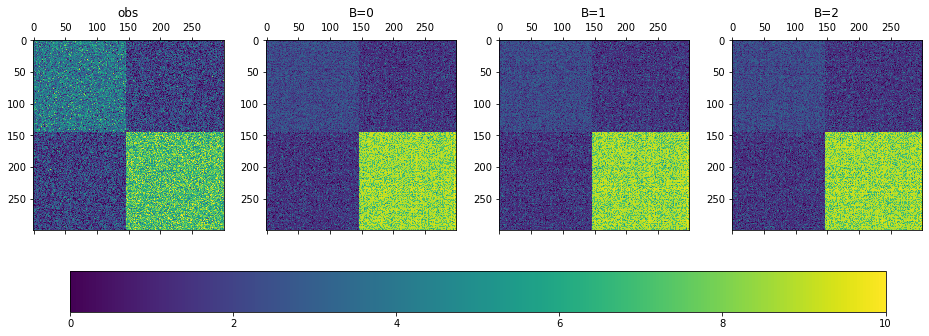

In [29]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

In [30]:
n_neighbors = 5

In [31]:
"""method 5"""
n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Binarise A, 0 maps to 0. All other values map to 1 -------------------------------
A_bin = np.where(A > 0, 1, 0)

# Estimate the binarised P from the binarised A -------------------------------
P_est_bin = P_est_from_A_obs(n, A_bin, n_neighbors=n_neighbors, indices=indices)

# Estimate the weighted P from A_obs -------------------------------
P_est = P_est_from_A_obs(n, A, n_neighbors=n_neighbors, indices=indices)

# Calculate the in and out weight vectors of A_obs -------------------------------  
out_weights = np.sum(A_obs, axis=1) #row sum
in_weights = np.sum(A_obs, axis=0) #column sum

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est_bin = make_inhomogeneous_rg(P_est_bin)
    A_est = P_est * A_est_bin

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

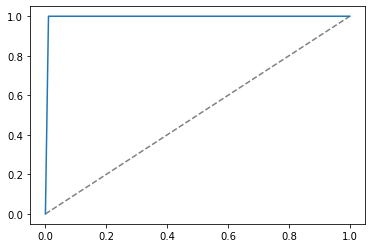

1.0

In [32]:
plot_power(p_vals, plot=True)

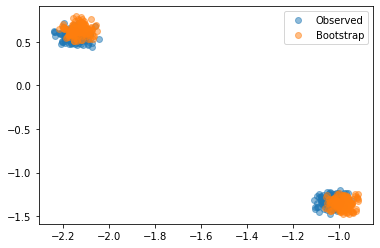

In [33]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=0.5)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=0.5)

plt.legend()

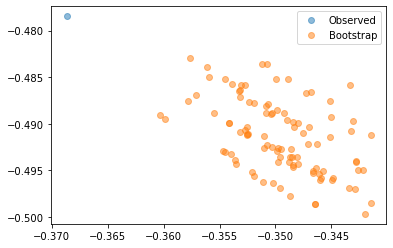

In [44]:
# append A_obs to the front of A_boots list
mats = [A_obs] + A_boots
# embed the whole thing
yhat_est = UASE(mats, d=K, flat=False)

# this plots the position of node i for the observed and all the bootstraps
i=3 # node index
plt.plot(yhat_est[0, i, 0], yhat_est[0, i, 1], 'o', label="Observed", alpha=0.5)
plt.plot(yhat_est[1:, i, 0], yhat_est[1:, i, 1], 'o', label="Bootstrap", alpha=0.5)

plt.legend()

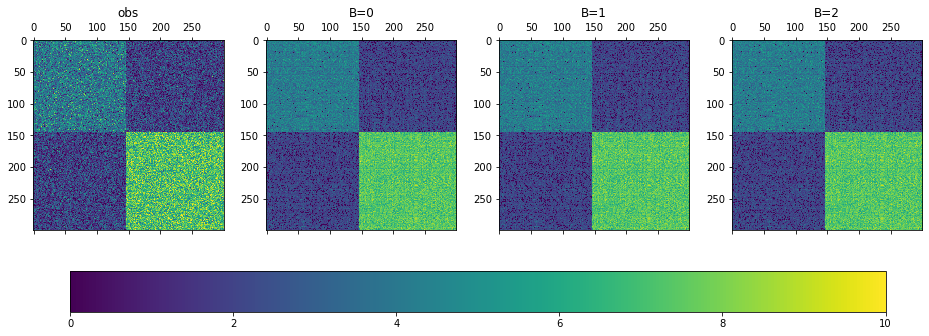

In [34]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')

### MAKE THE CORRECT MODEL ASSUMPTION

In [10]:
"""method 6"""

d=2
n_neighbors=5
B = 100

n = A_obs.shape[0]
A = A_obs.copy()

# Embed the graphs -------------------------------  
yhat = UASE([A], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults), 
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric='minkowski', p=2).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the weighted P from A_obs -------------------------------
P_est = P_est_from_A_obs(n, A, n_neighbors=n_neighbors, indices=indices)

# Give the number of trials in the binomial distribution -------------------------------
m = 10
Q_est = P_est/m # so A~Bin(m, Q_est)

# Bootstrap -----------------------------------------
# B = 100
p_vals = []
A_boots = []
for i in range(B):
    A_est = np.random.binomial(m, p=Q_est)

    yhat_est = UASE([A_obs,A_est], d=d)
    p_val = test_temporal_displacement_two_times(yhat_est, n)
    p_vals.append(p_val)
    A_boots.append(A_est)

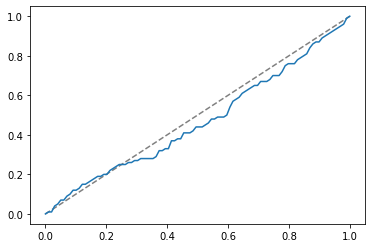

0.07

In [11]:
plot_power(p_vals, plot=True)

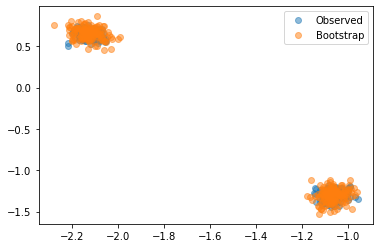

In [12]:
yhat_est = UASE([A_obs,A_est], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=0.5)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=0.5)

plt.legend()

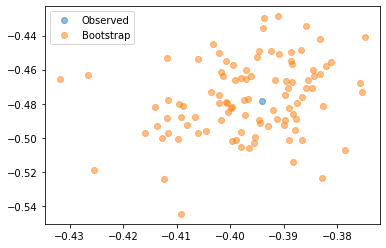

In [15]:
# append A_obs to the front of A_boots list
mats = [A_obs] + A_boots
# embed the whole thing
yhat_est = UASE(mats, d=K, flat=False)

# this plots the position of node i for the observed and all the bootstraps
i=2 # node index
plt.plot(yhat_est[0, i, 0], yhat_est[0, i, 1], 'o', label="Observed", alpha=0.5)
plt.plot(yhat_est[1:, i, 0], yhat_est[1:, i, 1], 'o', label="Bootstrap", alpha=0.5)

plt.legend()

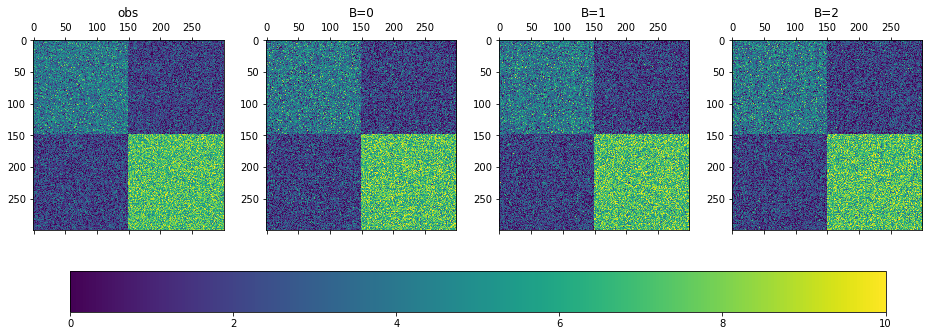

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('obs')
ax0.matshow(A_obs)
ax1.set_title('B=0')
ax1.matshow(A_boots[0])
ax2.set_title('B=1')
ax2.matshow(A_boots[1])
ax3.set_title('B=2')
ax3.matshow(A_boots[2])

# add the colourbar
fig.colorbar(cax, ax=[ax0, ax1, ax2, ax3], orientation='horizontal')